<a href="https://colab.research.google.com/github/anarlavrenov/Speech-Commands-Classifier/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchaudio
from IPython.display import Audio

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=".", subset="training", download=True)
valid_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=".", subset="validation", download=True)
test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=".", subset="testing", download=True)

100%|██████████| 2.26G/2.26G [00:24<00:00, 98.2MB/s]


In [3]:
labels_list = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five',
          'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left',
          'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila',
          'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [4]:
def transform_to_spectrogram(waveform):
  waveform = torch.tensor(waveform, dtype=torch.float32)

  if waveform.ndim > 1:
    waveform = torch.squeeze(waveform, dim=0)

  spectrogram = torchaudio.transforms.Spectrogram(
      n_fft=384,
      win_length=256,
      hop_length=160,
      power=None
  )(waveform).transpose(1, 0)

  spectrogram = torch.abs(spectrogram)
  spectrogram = torch.pow(spectrogram, 0.5)

  means = torch.mean(spectrogram, dim=1, keepdim=True)
  stddevs = torch.std(spectrogram, dim=1, keepdim=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)

  return spectrogram  # timeframes, n_mels

def plot_spectrogram(spectrogram):
  if spectrogram.dtype == torch.float:
    spectrogram = spectrogram.cpu().detach().numpy()

  spectrogram = spectrogram.transpose(1, 0) # n_mels, timeframes

  fig, ax = plt.subplots(1, 1, figsize=(12, 3))
  im1 = ax.imshow(spectrogram, aspect="auto", origin="lower", interpolation="none")
  plt.colorbar(im1, ax=ax)
  plt.tight_layout()
  plt.show()

In [5]:
def collate_fn(batch, max_duration=5, sample_rate=16000):

  filtered_batch = []

  for waveform, rate, label, *_ in batch:
    duration = len(waveform) / sample_rate
    if duration <= max_duration:
      filtered_batch.append((waveform, label))

  waveforms, labels = zip(*filtered_batch)
  batch_size = len(labels)

  spectrograms = [transform_to_spectrogram(wf) for wf in waveforms]
  max_spec_length = max([spec.shape[0] for spec in spectrograms])
  n_mels = spectrograms[0].shape[1]

  spectrograms_padded = torch.zeros(batch_size, max_spec_length, n_mels, dtype=torch.float32)
  for i, spec in enumerate(spectrograms):
    spectrograms_padded[i, :spec.shape[0], :] = spec

  labels = torch.LongTensor([labels_list.index(label) for label in labels])

  return spectrograms_padded, labels

In [6]:
def batchify(dataset, batch_size, shuffle=False):
  return torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=True,
      collate_fn=collate_fn
      )

train_loader = batchify(train_dataset, batch_size=256, shuffle=True)
valid_loader = batchify(valid_dataset, batch_size=32, shuffle=False)
test_loader = batchify(test_dataset, batch_size=32, shuffle=False)

In [7]:
src = next(iter(valid_loader))[0].to(device)
tgt = next(iter(valid_loader))[1].to(device)

torch.Size([101, 193])


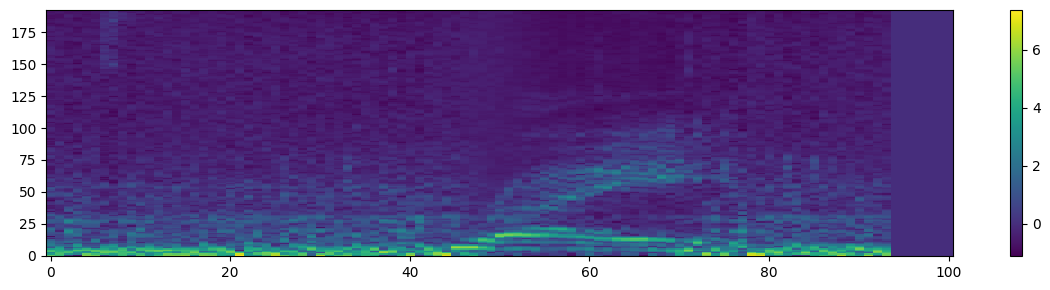

In [8]:
print(src[0].shape)
plot_spectrogram(src[0])

In [78]:
class EmotionClassifierModel(torch.nn.Module):
  def __init__(self, output_dim, n_mels=193, n_classes=35):
    super(EmotionClassifierModel, self).__init__()

    self.conv_block1 = self.conv_block(
        in_channels=1,
        out_channels=32,
        kernel_size=(11, 41),
        stride=(2, 2),
        padding=(5, 20),
        dilation=1,
        bias=False
    )

    self.conv_block2 = self.conv_block(
        in_channels=32,
        out_channels=32,
        kernel_size=(11, 21),
        stride=(1, 2),
        padding=(5, 10),
        dilation=1,
        bias=False
    )

    self.linear_block1 = self.linear_block(
        in_features=32 * 49,
        out_features=output_dim,
        activation=torch.nn.ReLU(),
        dropout=True
        )

    self.linear_block2 = self.linear_block(
        in_features=output_dim,
        out_features=n_classes,
        activation=None,
        dropout=False
        )

  def forward(self, src):
    src = torch.unsqueeze(src, 1)
    src = self.conv_block1(src)
    src = self.conv_block2(src)

    src = src.permute(0, 2, 1, 3)

    src = torch.mean(src, dim=1)
    src = src.reshape(src.shape[0], src.shape[1] * src.shape[2])

    src = self.linear_block1(src)
    output = self.linear_block2(src)

    return output

  def conv_block(self, in_channels, out_channels,
                 kernel_size, stride, padding, dilation, bias):
    block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels,
                kernel_size, stride, padding, dilation, bias=bias
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
    )

    torch.nn.init.xavier_uniform_(
        block[0].weight,
        gain=torch.nn.init.calculate_gain("relu"))

    return block

  def linear_block(self, in_features, out_features,
                   activation=None, dropout=False):
    block = torch.nn.Sequential(
        torch.nn.Linear(in_features, out_features)
    )

    if activation is not None:
      block.append(activation)
    if dropout == True:
      block.append(torch.nn.Dropout(0.5))

    torch.nn.init.xavier_uniform_(
        block[0].weight,
        gain=torch.nn.init.calculate_gain("linear"))

    return block

In [80]:
model = EmotionClassifierModel(
    output_dim=256
).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(loader):
  model.train()
  total_loss = 0
  total_accuracy = 0

  for batch in tqdm(loader, desc="Training"):
    optimizer.zero_grad()
    src, tgt = batch[0].to(device), batch[1].to(device)
    outputs = model(src)

    loss = criterion(outputs, tgt)
    total_loss += loss.item()
    accuracy = torch.sum((torch.argmax(outputs, dim=1) == tgt).int()).item() / len(tgt)
    total_accuracy += accuracy

    loss.backward()
    optimizer.step()

  return total_loss / len(loader), total_accuracy / len(loader)

def evaluate(loader):
  model.eval()
  total_loss = 0
  total_accuracy = 0

  with torch.no_grad():
    for batch in tqdm(loader, desc="Evaluation"):
      src, tgt = batch[0].to(device), batch[1].to(device)
      outputs = model(src)

      loss = criterion(outputs, tgt)
      total_loss += loss.item()
      accuracy = torch.sum((torch.argmax(outputs, dim=1) == tgt).int()).item() / len(tgt)
      total_accuracy += accuracy

  return total_loss / len(loader), total_accuracy / len(loader)

In [ ]:
epochs = 2

for epoch in range(epochs):
  loss, acc = train(train_loader)
  val_loss, val_acc = evaluate(valid_loader)

  print(f"Epoch: {epoch + 1} | loss: {loss:.3f} | acc: {acc:.3f} | val_loss: {val_loss:.3f} | val_acc: {val_acc:.3f}")

Evaluation: 100%|██████████| 311/311 [00:51<00:00,  6.05it/s]


Epoch: 1 | loss: 0.392 | acc: 0.882 | val_loss: 0.324 | val_acc: 0.905


Evaluation: 100%|██████████| 311/311 [00:52<00:00,  5.95it/s]

Epoch: 2 | loss: 0.387 | acc: 0.884 | val_loss: 0.320 | val_acc: 0.910


In [ ]:
y_pred = []
y_true = []

model.eval()

with torch.no_grad():
  for batch in test_loader:
    src, tgt = batch[0].to(device), batch[1].to(device)
    outputs = model(src)
    outputs = torch.argmax(outputs, dim=1)

    y_pred.append(outputs)

for batch in test_loader:
    src, tgt = batch[0].to(device), batch[1].to(device)
    y_true.append(tgt)

preds = torch.cat(y_pred).cpu().detach().numpy()
true = torch.cat(y_true).cpu().detach().numpy()

In [ ]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       165
           1       0.86      0.86      0.86       207
           2       0.89      0.80      0.84       185
           3       0.86      0.89      0.88       194
           4       0.88      0.81      0.85       220
           5       0.90      0.86      0.88       406
           6       0.88      0.91      0.90       408
           7       0.91      0.93      0.92       445
           8       0.85      0.70      0.77       172
           9       0.78      0.39      0.52       155
          10       0.75      0.94      0.84       371
          11       0.85      0.77      0.81       402
          12       0.94      0.86      0.89       203
          13       0.95      0.89      0.92       191
          14       0.60      0.84      0.70       161
          15       0.92      0.85      0.88       412
          16       0.94      0.87      0.91       195
          17       0.90    

In [ ]:
def run_inference(idx, dataset=test_dataset):
  model.eval()
  with torch.no_grad():
    sample = test_dataset[idx]
    waveform, true_label = sample[0], sample[2]
    spectrogram = transform_to_spectrogram(waveform).to(device)
    pred_logits = model(spectrogram.unsqueeze(0))
    pred_idx = torch.argmax(pred_logits, dim=1)
    pred_label = labels_list[pred_idx.item()]

  print(f"Pred: {pred_label}, True: {true_label}")

In [ ]:
idx = torch.randint(0, len(test_dataset), (1, ))

run_inference(idx.item())

Pred: one, True: on
